<a href="https://colab.research.google.com/github/student-monika/Marvel_tasks_Level_2/blob/main/Generative_Adversarial_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch [1/7] Batch 0/391                   Loss D: 1.4324, Loss G: 1.3698
Epoch [1/7] Batch 100/391                   Loss D: 0.0302, Loss G: 6.7441
Epoch [1/7] Batch 200/391                   Loss D: 0.6288, Loss G: 13.9211
Epoch [1/7] Batch 300/391                   Loss D: 0.1494, Loss G: 5.1149


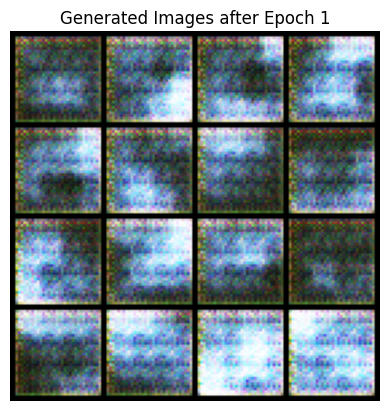

Epoch [2/7] Batch 0/391                   Loss D: 0.3436, Loss G: 8.5485
Epoch [2/7] Batch 100/391                   Loss D: 0.1551, Loss G: 3.6500
Epoch [2/7] Batch 200/391                   Loss D: 0.0717, Loss G: 4.5180
Epoch [2/7] Batch 300/391                   Loss D: 0.2384, Loss G: 6.0660


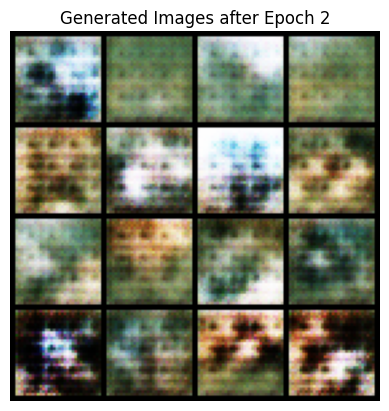

Epoch [3/7] Batch 0/391                   Loss D: 0.1459, Loss G: 4.3349
Epoch [3/7] Batch 100/391                   Loss D: 0.1701, Loss G: 4.3600
Epoch [3/7] Batch 200/391                   Loss D: 0.1426, Loss G: 4.6074
Epoch [3/7] Batch 300/391                   Loss D: 0.2758, Loss G: 4.8951


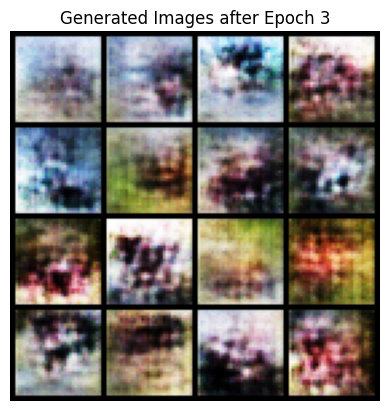

Epoch [4/7] Batch 0/391                   Loss D: 0.2620, Loss G: 4.5100
Epoch [4/7] Batch 100/391                   Loss D: 0.1368, Loss G: 4.8729
Epoch [4/7] Batch 200/391                   Loss D: 0.1831, Loss G: 4.7602
Epoch [4/7] Batch 300/391                   Loss D: 0.2541, Loss G: 3.4485


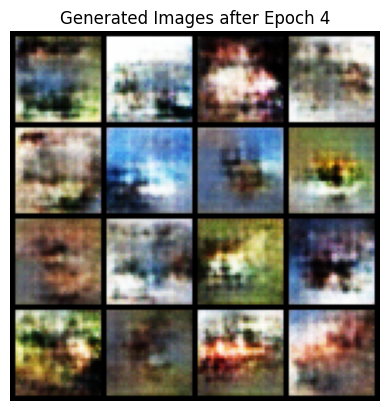

Epoch [5/7] Batch 0/391                   Loss D: 0.4743, Loss G: 6.0682
Epoch [5/7] Batch 100/391                   Loss D: 0.2265, Loss G: 4.0229
Epoch [5/7] Batch 200/391                   Loss D: 0.1355, Loss G: 3.9776
Epoch [5/7] Batch 300/391                   Loss D: 0.1500, Loss G: 4.4797


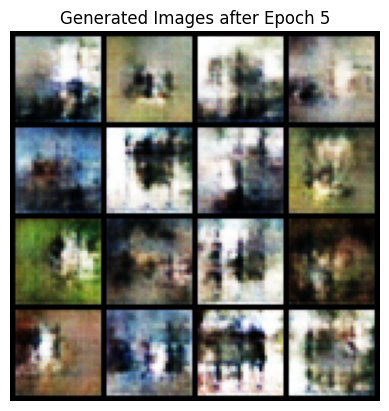

Epoch [6/7] Batch 0/391                   Loss D: 0.2465, Loss G: 4.8677
Epoch [6/7] Batch 100/391                   Loss D: 0.1657, Loss G: 3.6601
Epoch [6/7] Batch 200/391                   Loss D: 0.1459, Loss G: 3.7678
Epoch [6/7] Batch 300/391                   Loss D: 0.5130, Loss G: 3.2483


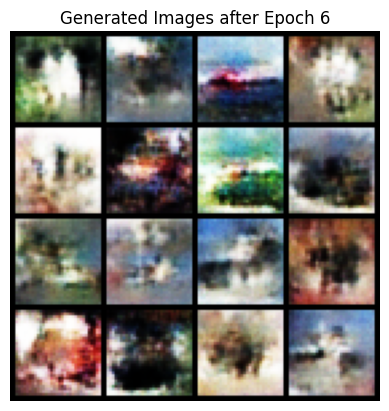

Epoch [7/7] Batch 0/391                   Loss D: 0.2235, Loss G: 4.1400
Epoch [7/7] Batch 100/391                   Loss D: 0.3501, Loss G: 2.4261
Epoch [7/7] Batch 200/391                   Loss D: 0.2728, Loss G: 3.7913
Epoch [7/7] Batch 300/391                   Loss D: 2.0699, Loss G: 1.1171


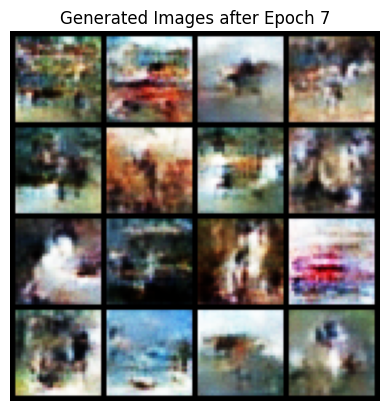

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
image_size = 32
channels = 3
latent_dim = 100
batch_size = 128
epochs = 7
lr = 0.0002
beta1 = 0.5

# Data loading
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)  # Normalize to [-1, 1]
])
dataset = datasets.CIFAR10(root='./data', download=True, transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Generator
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 256*4*4),
            nn.BatchNorm1d(256*4*4),
            nn.ReLU(True),
            nn.Unflatten(1, (256, 4, 4)),
            nn.ConvTranspose2d(256, 128, 4, 2, 1),  # 4x4 -> 8x8
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1),   # 8x8 -> 16x16
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, channels, 4, 2, 1),  # 16x16 -> 32x32
            nn.Tanh()
        )

    def forward(self, z):
        return self.model(z)

# Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(channels, 64, 4, 2, 1),   # 32x32 -> 16x16
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1),        # 16x16 -> 8x8
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1),       # 8x8 -> 4x4
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Flatten(),                      # shape = 256*4*4 = 4096
            nn.Linear(256*4*4, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        return self.model(img)

# Initialize models
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Loss and optimizers
criterion = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))

# Training
for epoch in range(epochs):
    for i, (imgs, _) in enumerate(dataloader):
        batch_size = imgs.size(0)

        real_imgs = imgs.to(device)
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # Train Discriminator
        z = torch.randn(batch_size, latent_dim).to(device)
        fake_imgs = generator(z)

        real_loss = criterion(discriminator(real_imgs), real_labels)
        fake_loss = criterion(discriminator(fake_imgs.detach()), fake_labels)
        d_loss = real_loss + fake_loss

        optimizer_D.zero_grad()
        d_loss.backward()
        optimizer_D.step()

        # Train Generator
        g_loss = criterion(discriminator(fake_imgs), real_labels)

        optimizer_G.zero_grad()
        g_loss.backward()
        optimizer_G.step()

        if i % 100 == 0:
            print(f"Epoch [{epoch+1}/{epochs}] Batch {i}/{len(dataloader)} \
                  Loss D: {d_loss.item():.4f}, Loss G: {g_loss.item():.4f}")

    # Show a few generated images
    with torch.no_grad():
        z = torch.randn(16, latent_dim).to(device)
        samples = generator(z).cpu()
        samples = (samples + 1) / 2  # Denormalize
        grid = np.transpose(torchvision.utils.make_grid(samples, nrow=4), (1, 2, 0))
        plt.imshow(grid)
        plt.title(f"Generated Images after Epoch {epoch+1}")
        plt.axis("off")
        plt.show()
